# Semester Project - Materials Informatics

## 1 Evolving interpretable features with GPSR

In [31]:
#imports 
#CBFV
import CBFV 
from CBFV import composition
from CBFV.composition import generate_features

#pymatgen
# import pymatgen.core as mg
# from pymatgen.ext.matproj import MPRester
# coop_API = '7wZ5nUEFSNRTXs9a' #an API from some data website
# mpr = MPRester(coop_API)

#umap/hdbscan
import umap
import hdbscan

#general
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from scipy.special import logit

#sklearn
import sklearn as skl
from sklearn.ensemble import *
from sklearn import svm
from sklearn.preprocessing import *
import sklearn.model_selection as ms
from sklearn.metrics import *

import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid")

### 1.1 IN625 Microstructure Data

In [47]:
import umap
import hdbscan
from scipy.stats import randint

#read in data
data = pd.read_csv('hi_with_num_high_schmids_04.csv', keep_default_na=False) #threshold 0.4

#normalize and split data
X_arr = data.drop(columns=['FIP']).to_numpy() #inputs as array
scaler = StandardScaler()
X_norm = normalize(scaler.fit_transform(X_arr))
# rebuild data frame with normalized data
data_norm = pd.DataFrame(X_norm,columns=data.drop(columns=['FIP']).columns)
data_norm['FIP'] = data['FIP']
X_train, X_test, y_train, y_test = ms.train_test_split(data_norm.drop(columns=['FIP']),data_norm['FIP'], test_size=0.20, random_state=42)

#### 1.1.1 UMAP and HDBSCAN on Microstructure Data

Text(0.5, 0.98, 'UMAP and HDBSCAN')

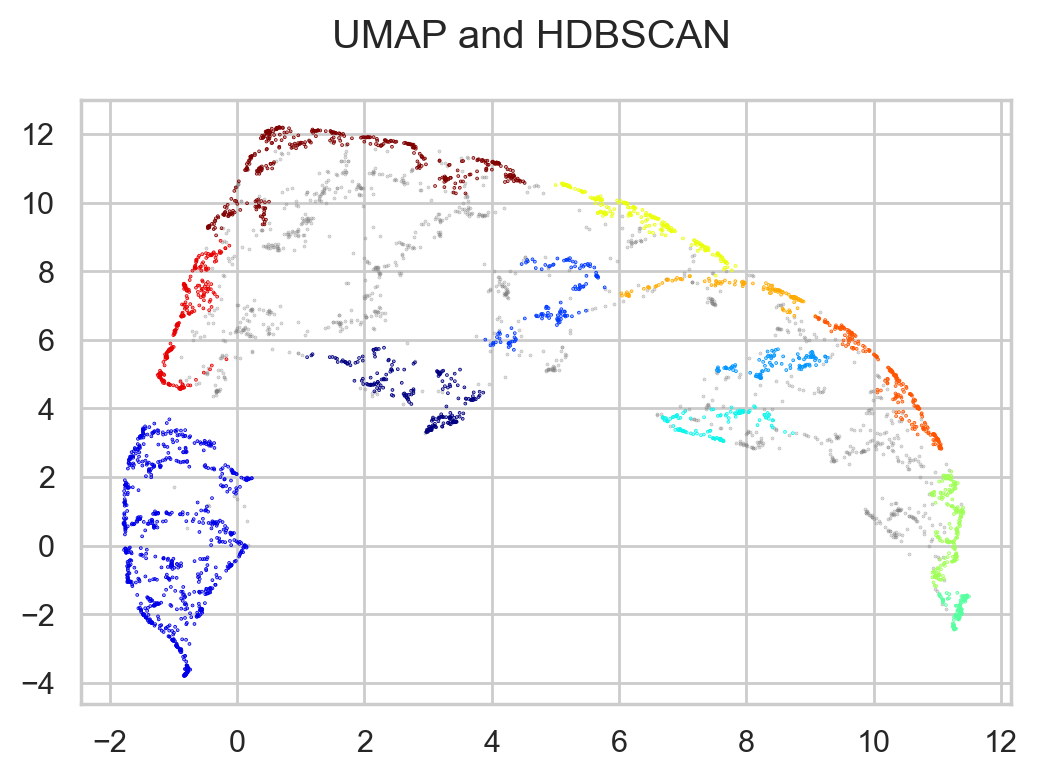

In [48]:
standard_embedding_m = umap.UMAP(random_state=42,n_neighbors=100,min_dist = 0.0).fit_transform(data)

clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=2,
    random_state=42,
).fit_transform(data)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)
fig,ax = plt.subplots(1,1,dpi=200)
ax.scatter(standard_embedding_m[~clustered, 0],
            standard_embedding_m[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
ax.scatter(standard_embedding_m[clustered, 0],
            standard_embedding_m[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='jet');
fig.suptitle('UMAP and HDBSCAN')

#grab normalized data and calculate new features from FEAT



#### 1.1.2 Random Forest vs Evolved features from FEAT

    importances                          features
3      0.218425               Grain Size of Grain
0      0.089747               Max Schmid of Grain
8      0.061921               Number of Neighbors
4      0.061306                           m-prime
5      0.060640               Sphericity of Grain
6      0.058094                  Delta Max Schmid
1      0.056703                Max Misorientation
2      0.055416               Shared Surface Area
7      0.055145                  Delta Grain Size
9      0.052314   Number of High Neighbor Schmids
13     0.050299  Schmid Dominance Factor in Grain
14     0.046626          Schmid Variance in Grain
10     0.044754      Number of High Grain Schmids
11     0.044340           Delta Number of Schmids
12     0.044269    Average Schmid Factor of Grain


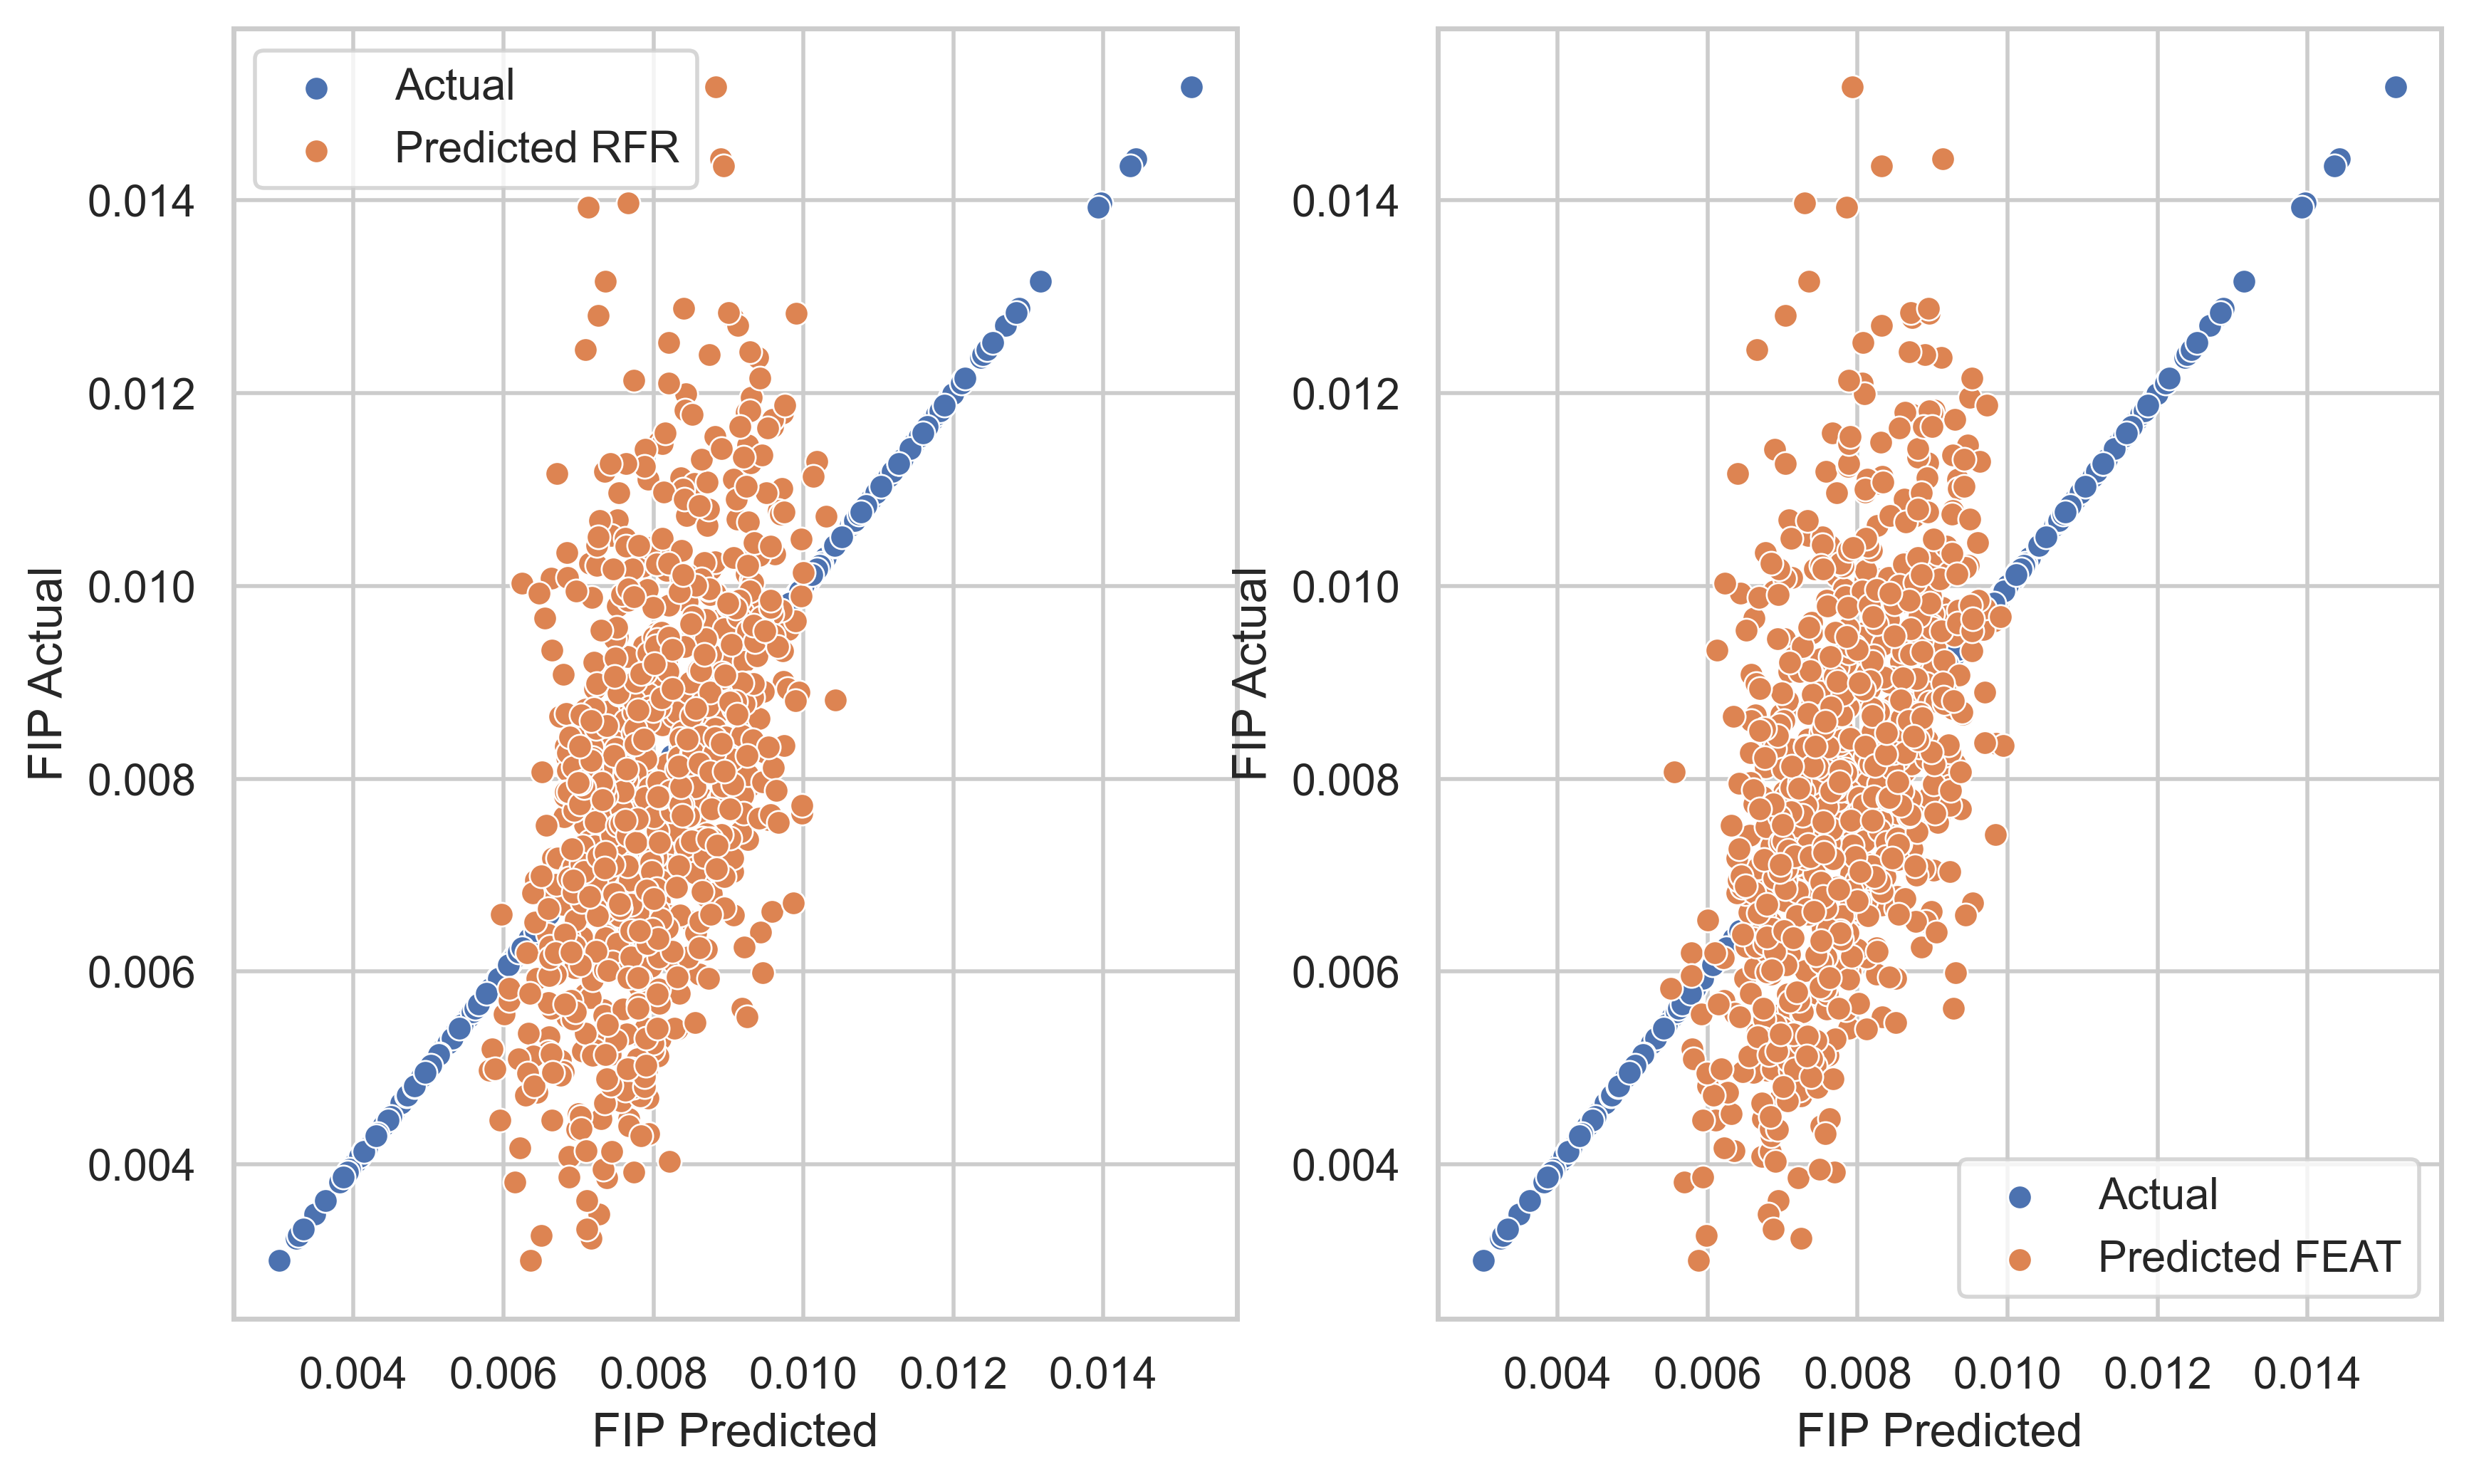

In [58]:
#random forest prediction
reg = skl.ensemble.RandomForestRegressor(max_features='auto', n_estimators=100, min_samples_split=6)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

#FEAT prediction
y_FEAT_pred = pd.read_csv('FEAT_pred.csv',header=0)


#plot comparison
fig,axs = plt.subplots(1,2,figsize=(10,6),dpi=400)
#random forest
sns.scatterplot(ax=axs[0],x=y_test,y=y_test,palette='deep',label='Actual')
sns.scatterplot(ax=axs[0],x=y_pred,y=y_test,palette='deep',label='Predicted RFR')
#FEAT
sns.scatterplot(ax=axs[1],x=y_test,y=y_test,palette='deep',label='Actual')
sns.scatterplot(ax=axs[1],x=exp(y_FEAT_pred['0']),y=y_test,palette='deep',label='Predicted FEAT')

axs[0].set_ylabel('FIP Actual')
axs[0].set_xlabel('FIP Predicted')
axs[1].set_ylabel('FIP Actual')
axs[1].set_xlabel('FIP Predicted')


importance = pd.DataFrame({'importances':reg.feature_importances_, 'features': X_train.columns})
print(importance.sort_values(by=['importances'],ascending=False))


### 1.2 Vickers Hardness Data From HW3

In [59]:
# functionality
def CBFV_loop(df,feature_names):
    extendedfeats = []
    for name in feature_names:
        X, y_cur, formula, skip = composition.generate_features(df.rename(columns={name: "target"}))
        extendedfeats.append(y_cur)
        
    return X, extendedfeats

#import data
train = pd.read_csv('train.csv')

# Create input 'feature_data'
feature_data = train.loc[:, ['formula','target']].dropna(axis=0)
feature_data.rename(columns={'target':'Vickers'}, inplace=True)
feature_data.reset_index(drop=True,inplace=True)

# Generate Features using CBFV 
X, extendedfeats = CBFV_loop(feature_data,['Vickers'])
y = extendedfeats[0]

# #normalize and split
X['target'] = y
# name columns for after normalization 
cols = X.columns
scaler = StandardScaler()
X = normalize(scaler.fit_transform(X))
# create dataframe again
X = pd.DataFrame(X,columns=cols)
X_train, X_test, y_train, y_test = ms.train_test_split(X.drop(columns=['target']), X['target'])

# Send to csv for use in FEAT
X.to_csv('feature_data.csv',index=False)

Processing Input Data: 100%|██████████████████████████████████████████████████████| 861/861 [00:00<00:00, 13046.16it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████████████████████████████████████████████| 861/861 [00:00<00:00, 9305.88it/s]


	Creating Pandas Objects...


C:\Users\coope\AppData\Local\Temp\ipykernel_28224\3192966558.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['target'] = y


#### 1.2.1 UMAP and HDBSCAN on CBFV and Vicker's Data

Text(0.5, 0.98, 'UMAP and HDBSCAN')

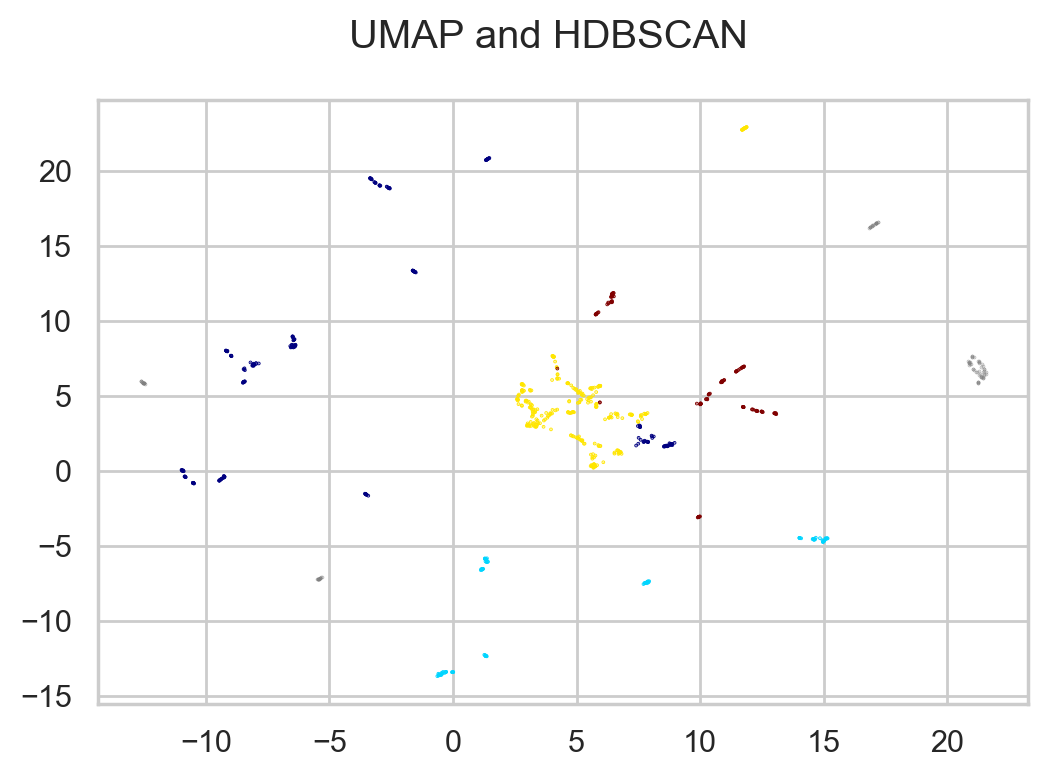

In [40]:
#embedding the unevolved high dimensional data
standard_embedding_m = umap.UMAP(random_state=42).fit_transform(X)

#clustering utilizing hdbscan
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)


clustered = (labels >= 0)
fig,ax = plt.subplots(1,1,dpi=200)
ax.scatter(standard_embedding_m[~clustered, 0],
            standard_embedding_m[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
ax.scatter(standard_embedding_m[clustered, 0],
            standard_embedding_m[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='jet');
fig.suptitle('UMAP and HDBSCAN')

#### 1.2.2 Random Forest vs Evolved features from FEAT

     importances                      features
5       0.199846                     avg_Metal
258     0.120676   mode_specific_heat_(J/g_K)_
7       0.091975                 avg_Metalliod
15      0.075808            avg_crystal_radius
235     0.073678           mode_crystal_radius
..           ...                           ...
157     0.000036                 max_valence_p
138     0.000030                  max_Nonmetal
95      0.000029               range_Metalliod
171     0.000028  max_heat_of_fusion_(kJ/mol)_
183     0.000000                 min_Metalliod

[264 rows x 2 columns]


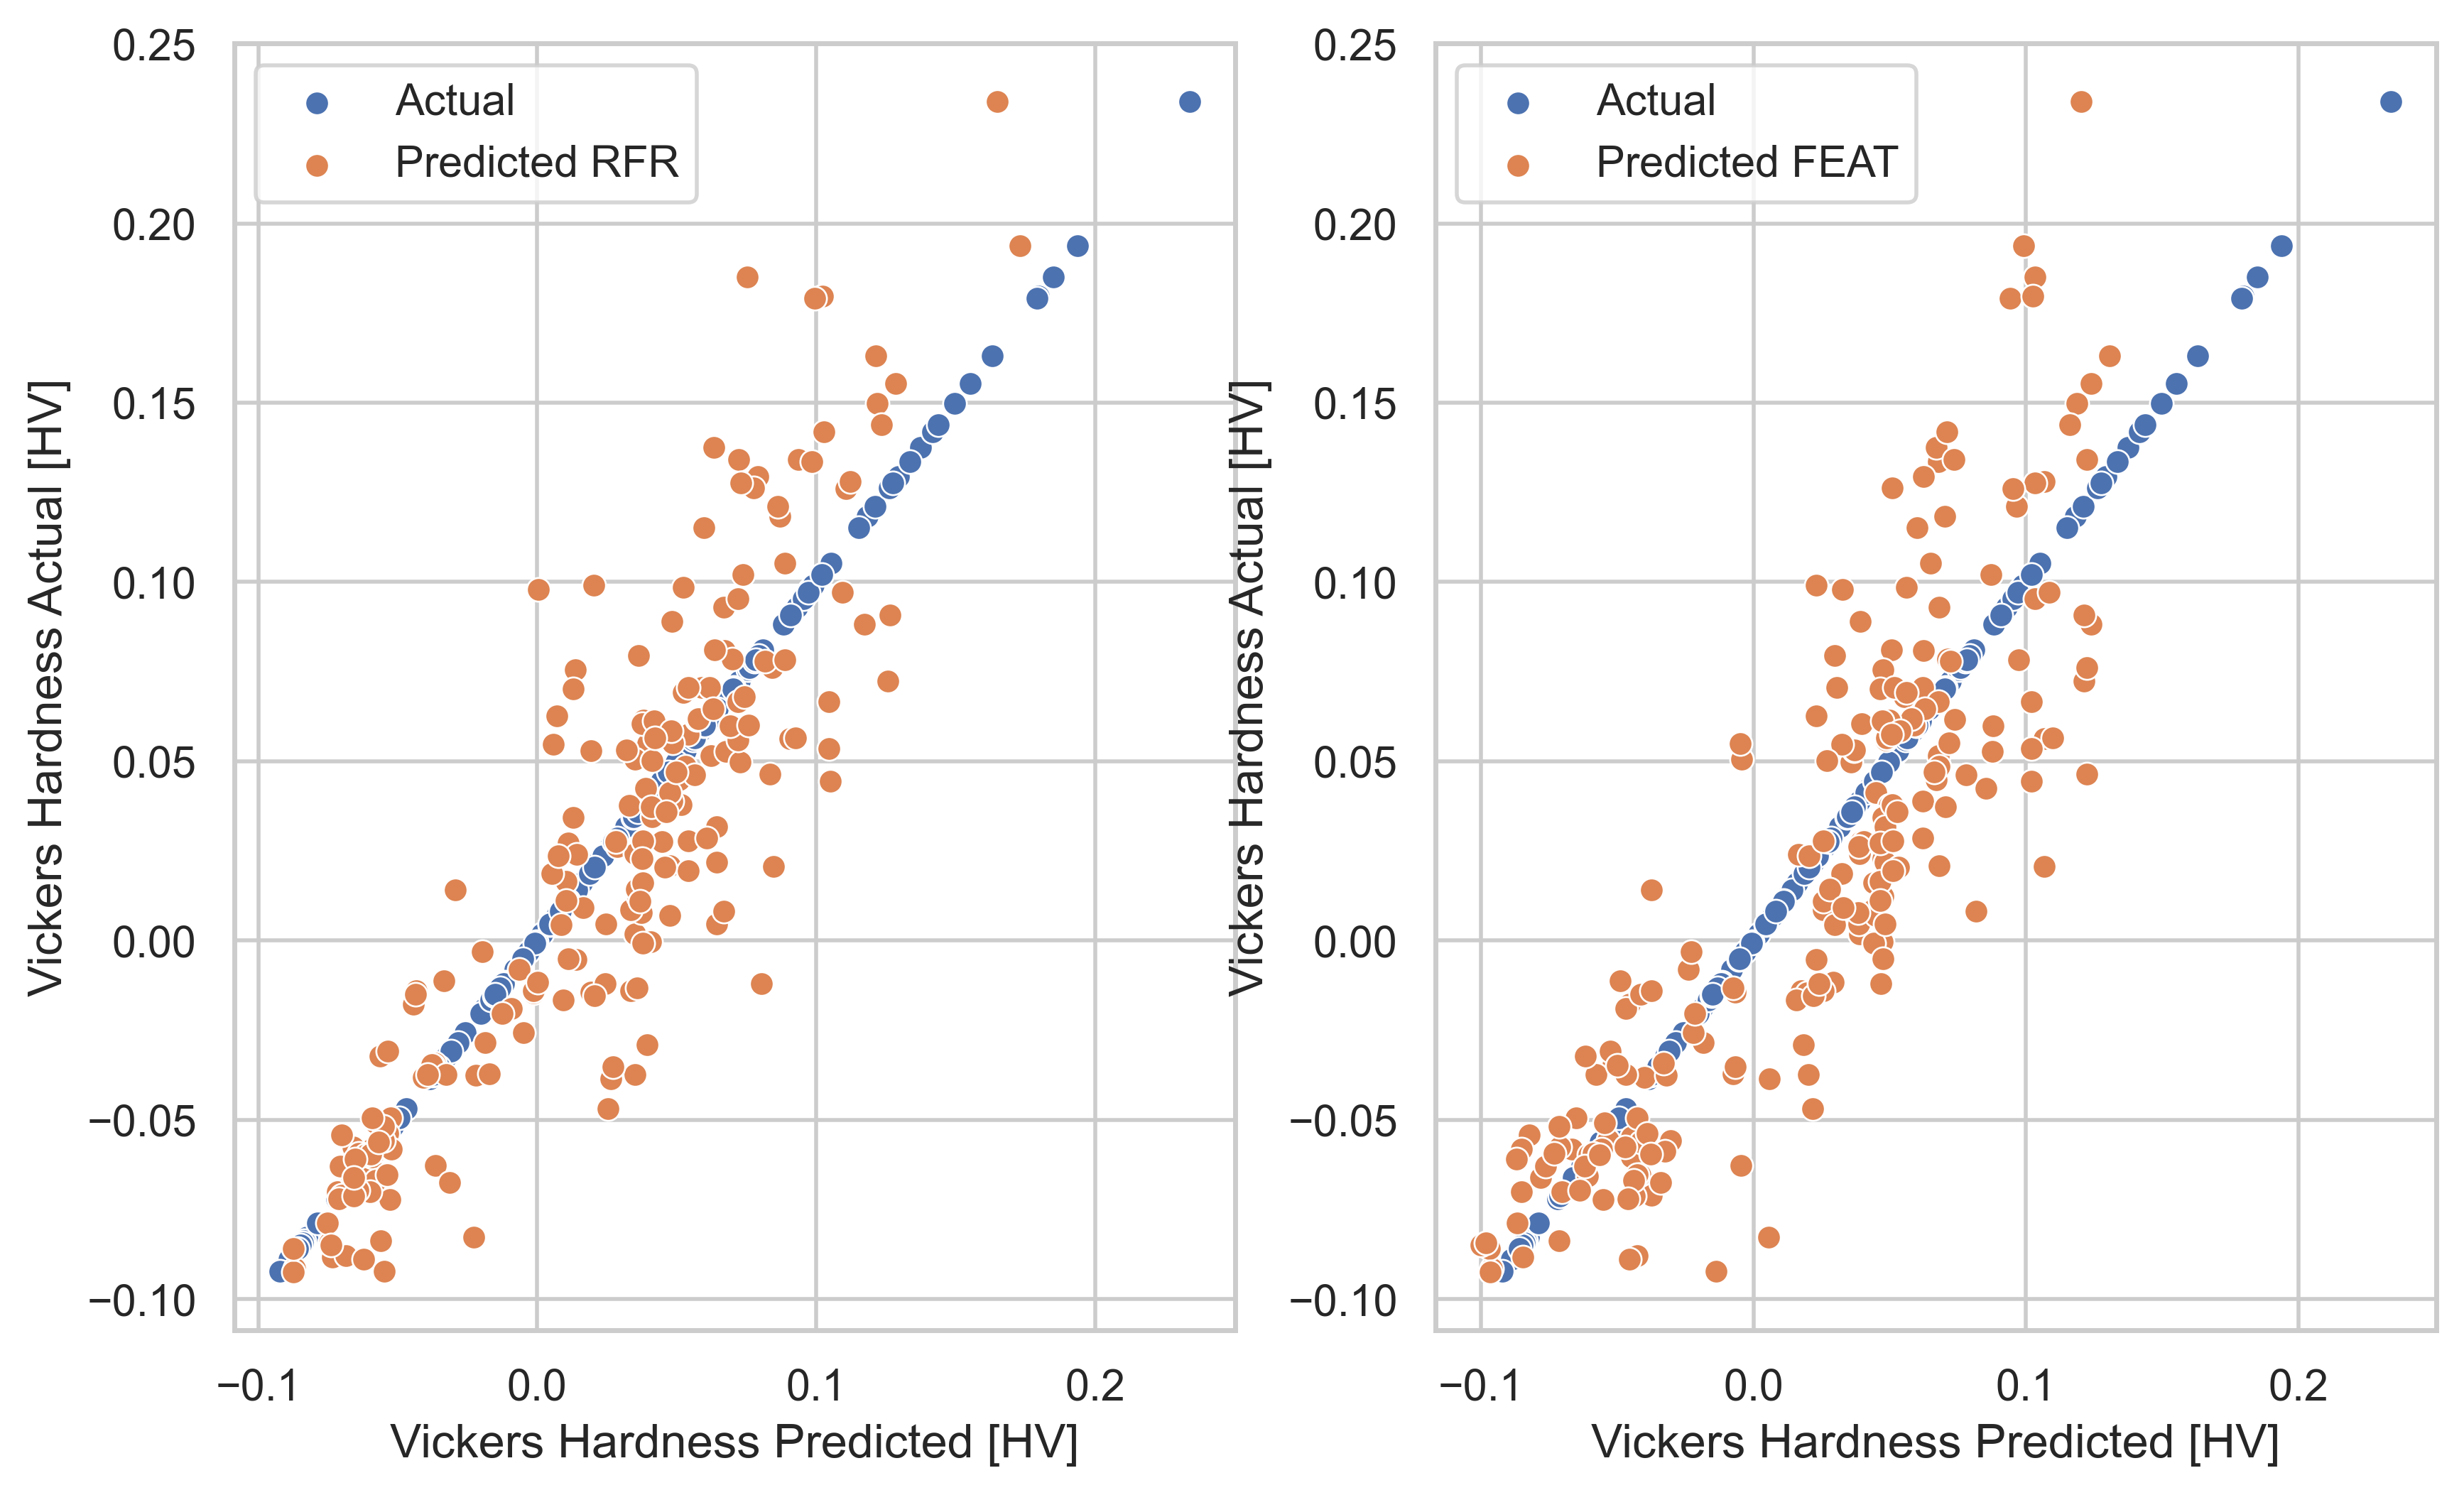

In [63]:
#random forest prediction
reg = skl.ensemble.RandomForestRegressor(max_features='auto', n_estimators=100, min_samples_split=6)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

#FEAT prediction
y_FEAT_pred_Vickers = pd.read_csv('FEAT_pred_Vickers.csv',header=0)

#plot comparison
fig,axs = plt.subplots(1,2,figsize=(10,6),dpi=400)
#random forest
sns.scatterplot(ax=axs[0],x=y_test,y=y_test,palette='deep',label='Actual')
sns.scatterplot(ax=axs[0],x=y_pred,y=y_test,palette='deep',label='Predicted RFR')
#FEAT
sns.scatterplot(ax=axs[1],x=y_test,y=y_test,palette='deep',label='Actual')
sns.scatterplot(ax=axs[1],x=y_FEAT_pred_Vickers['0'],y=y_test,palette='deep',label='Predicted FEAT')

axs[0].set_ylabel('Vickers Hardness Actual [HV]')
axs[0].set_xlabel('Vickers Hardness Predicted [HV]')
axs[1].set_ylabel('Vickers Hardness Actual [HV]')
axs[1].set_xlabel('Vickers Hardness Predicted [HV]')

importance = pd.DataFrame({'importances':reg.feature_importances_, 'features': X_train.columns})
print(importance.sort_values(by=['importances'],ascending=False))

## 2 Code From Terminal for FEAT

A specific environment is needed to run this code which is not included here as it is far easier to install in terminal.

### 2.1 Code for IN625 and Vickers

In [ ]:
#import
from feat import Feat
import pandas as pd
import numpy as np
from sklearn.preprocessing import *

# import data
Vickers_df = pd.read_csv('feature_data.csv',header=0) #matinfo
micro_df = pd.read_csv('hi_with_num_high_schmids_04.csv',header=0) #research

X = Vickers_df.drop(columns=['target']).to_numpy(dtype=float)
y = Vickers_df['target'].to_numpy(dtype=float)

# setup
random_state = 42

fest = Feat(pop_size=500, # population size
            gens=1000, # maximum generations
            max_time=600, # max time in seconds
            max_depth=2, # constrain features depth
            max_dim=5, # constrain representation dimensionality
            random_state=random_state,
            hillclimb=True, # use stochastic hillclimbing to optimize weights
            scorer = 'rmse',
            iters=100, # iterations of hillclimbing
            n_jobs=1, # restricts to single thread
            functions = '+,-,/,*,exp,log,sqrt',
            verbosity= 1, # verbose output,
            otype='f',
            normalize=False
           )

y = np.ravel(y)
fest.fit(X,y)
print(fest.get_model(sort=False))
y_pred = pd.DataFrame(fest.predict(X))
y_pred.to_csv('FEAT_pred_Vickers.csv',index=False)
~                                                  

### Code for simple linear equation test in FEAT

In [ ]:
import numpy as np
import pandas as pd
from feat import Feat
from feat import FeatRegressor

POP = 500
GENS = 0
HILLCLIMB = True
NORM = False
ITERS = 10

#Linear Data 
# 2x + 3

print("LINEAR DATASET: 2x+3")
df = pd.read_excel("linear_data.xlsx").to_numpy()
x = df[:, 0].reshape(df.shape[0], 1)
# y = df[:, 1].reshape(df.shape[0], 1)
y = df[:, 1].ravel()
funcs = "+,*"

feat = Feat(pop_size=POP, gens=GENS, hillclimb=HILLCLIMB,
            iters=ITERS, n_jobs=12, verbosity=2,
            otype='f', functions=funcs, normalize=NORM,
            simplify=0.01)
feat.fit(x, y)
print(feat.get_eqn())
feat.predict(x)         